# Attention实例 -- Spatial Transformer

在用深度学习解决的图像和文本处理等任务中，注意力(Attention)的机制可以让我们获得输出结果的同时，了解到输入数据的哪些部分（如图像的某个区域，文档的某几句话）对结果的影响最大。注意力通常可以改进模型的表现，并增强模型的可解释性。

在图像处理和识别中，注意力有不同的实现方式。这里我们看一看Spetial Transformer这一种相对容易理解的方法。下面用MNIST分类任务来演示它的原理。

目录：
- Cluttered MNIST
- 原方法：CNN
- 新方法：ST-CNN

参考资料：
- https://github.com/oarriaga/spatial_transformer_networks/blob/master/src/mnist_cluttered_example.ipynb
- [Spatial Transformer Networks](http://arxiv.org/abs/1506.02025)

## Cluttered MNIST

前面我们已经看到，CNN可以在MNIST的分类上达到99%以上的准确率。现在我们给这个任务增加一些难度：将$28 \times 28$的数字放到$60\times 60$的图片中，并在里面加入一些疑似数字的形状（如笔画， 见下面的例图）。这样处理过的图像称为Cluttered MNIST（[下载](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz)）。 它的分类比MNIST要难一些，因为分类器需要找到数字在图像中的位置，并排除新加入的形状的干扰。

In [4]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import Input
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD
import keras

import keras.backend as K
from spatial_transformer import SpatialTransformer

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

Using TensorFlow backend.


In [5]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))


input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
Input shape: (60, 60, 1)


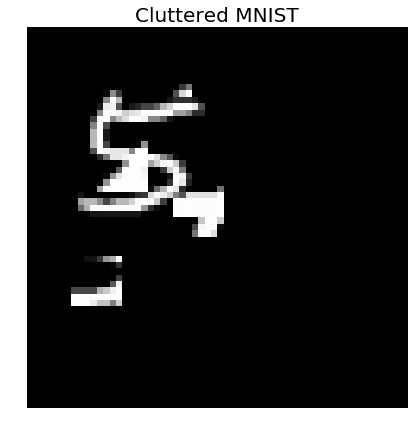

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

## 原方法：CNN

既然CNN可以在MNIST分类上达到$99\%$的准确率，我们不妨还用类似的模型来在Cluttered CNN上面运行一下。下面是一个比之前的MNIST的CNN模型多了几层的一个网络。

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
__________

In [ ]:
train_info = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128, #
    epochs=30,
    verbose=2
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
325s - loss: 2.0313 - acc: 0.2585 - val_loss: 1.3407 - val_acc: 0.5776
Epoch 2/30
324s - loss: 0.9044 - acc: 0.7027 - val_loss: 0.4743 - val_acc: 0.8613
Epoch 3/30
324s - loss: 0.4669 - acc: 0.8589 - val_loss: 0.3335 - val_acc: 0.8972
Epoch 4/30
325s - loss: 0.3289 - acc: 0.9002 - val_loss: 0.2425 - val_acc: 0.9254
Epoch 5/30
325s - loss: 0.2561 - acc: 0.9241 - val_loss: 0.2196 - val_acc: 0.9306
Epoch 6/30
325s - loss: 0.2115 - acc: 0.9360 - val_loss: 0.1807 - val_acc: 0.9453
Epoch 7/30
324s - loss: 0.1809 - acc: 0.9445 - val_loss: 0.1825 - val_acc: 0.9428
Epoch 8/30
325s - loss: 0.1550 - acc: 0.9516 - val_loss: 0.1502 - val_acc: 0.9536
Epoch 9/30
325s - loss: 0.1361 - acc: 0.9584 - val_loss: 0.1434 - val_acc: 0.9568
Epoch 10/30
325s - loss: 0.1205 - acc: 0.9628 - val_loss: 0.1472 - val_acc: 0.9575
Epoch 11/30
324s - loss: 0.1127 - acc: 0.9657 - val_loss: 0.1339 - val_acc: 0.9586
Epoch 12/30
324s - loss: 0.1023 - acc: 0.9687 

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.figure()
plt.plot(train_info.history['acc'])
plt.plot(train_info.history['val_acc'])
plt.legend(['train', 'validation'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.figure()
plt.plot(train_info.history['loss'])
plt.plot(train_info.history['val_loss'])
plt.legend(['train', 'validation'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()

Cluttered MNIST果然比MNIST困难，现在CNN只能达到大约$96\%$的准确率了。虽然我们可以微调各种参数来将CNN的能力发挥到极致，下面还是试试加入注意力之后效果怎么样。

## 新方法：ST-CNN

这个方法的想法很简单，就是将两个神经网络模块连接起来：
1. 一个称为Spatial Transformer的注意力网络(ST)，负责从每一张cluttered MNIST图像里提取出需要识别的数字。这个模块可以是MLP，CNN或其他任何**可训练**的网络
2. 一个负责识别数字的CNN，可以用和之前识别MNIST的CNN很相近的网络结构

这两个网络结合起来就称为ST-CNN。下面的图展示了ST-CNN的整体结构，以及上述两个模块所处的位置。

<img src="st_cnn.png">

(ST-CNN结构示意图， 来源：由[Spatial Transformer Networks](http://arxiv.org/abs/1506.02025)内Figure 2修改而成)


下面来建造这个网络。

In [6]:
# localization net
# TODO: try more conv layers, and do max pooling on X- and Y-axes respectively
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]


locnet = Sequential()
# locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
# locnet.add(Convolution2D(32, (5, 5)))
locnet.add(Convolution2D(32, (5, 5), input_shape=input_shape))
locnet.add(Activation('relu'))
# locnet.add(Dropout(0.2)) # 0.2
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(64, (5, 5)))
locnet.add(Activation('relu'))
# locnet.add(Dropout(0.2)) # 0.3
locnet.add(Convolution2D(64, (3, 3)))
locnet.add(Activation('relu'))
locnet.add(MaxPooling2D(pool_size=(2,2)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))

locnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 22, 22, 64)        0         
__________

In [ ]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             output_size=(30,30), input_shape=input_shape))


# model.add(Convolution2D(32, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Convolution2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5)) # 0.25

# E: removed first 3 dropout layers

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.5)) # 0.5
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5)) # 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(Dropout(0.5)) # 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256)) # 256
model.add(Dropout(0.5)) # 0.5
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adadelta(), #'adam',
    metrics=[keras.metrics.categorical_accuracy]
)

model.summary()

In [ ]:
train_info = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128, # 64
    epochs=30,
    verbose=2
)

In [142]:
model.evaluate(X_test, y_test)

 9824/10000 [============================>.] - ETA: 0s

[0.12665848220586776, 0.97460000000000002]

准确率相比CNN提高了一些。而且注意上面的两个网络里，ST-CNN用的参数较少。

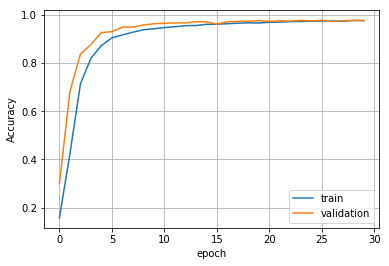

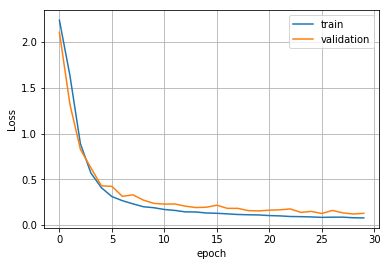

In [143]:
plt.figure()
plt.plot(train_info.history['categorical_accuracy'])
plt.plot(train_info.history['val_categorical_accuracy'])
plt.legend(['train', 'validation'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.figure()
plt.plot(train_info.history['loss'])
plt.plot(train_info.history['val_loss'])
plt.legend(['train', 'validation'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()

最后来看看ST-CNN是否真的准确地将注意力放到了要分类的数字上。

In [121]:
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

Xaug = X_test[:9]
Xresult = F([Xaug.astype('float32')])

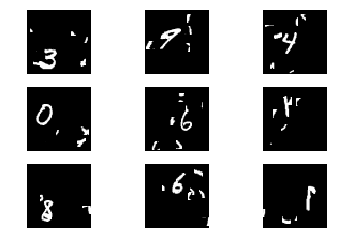

In [122]:
# locnet+sampler的输入图像：cluttered MNIST
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

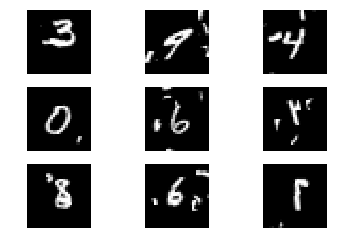

In [123]:
# locnet+sampler输出：注意力集中的区域
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

注意力确实成功训练出来了。